In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import warnings;
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
## Plotting settings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

TITLE_SIZE = 45
LABEL_SIZE = 40
LEGEND_TITLE_SIZE = 30
LEGEND_SIZE = 30
TICK_SIZE = 30
FONT = 'serif'
params = {}
params['legend.title_fontsize'] = LEGEND_TITLE_SIZE
params['axes.labelsize'] = LABEL_SIZE
params['axes.titlesize'] = TITLE_SIZE
params['legend.fontsize'] = LEGEND_SIZE
params["xtick.labelsize"]= TICK_SIZE
params["ytick.labelsize"] = TICK_SIZE
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="whitegrid", font=FONT)

## LibFM $\rho^*$ vs baseline $\rho$ in low and high stochasticity settings for a range of action space sizes.

### All plots in this notebook use reachability experiment results for MovieLens 1Million dataset

To illustrates the effect of action space size we use the results of reachability experiments for one user: `USER_ID = 29`

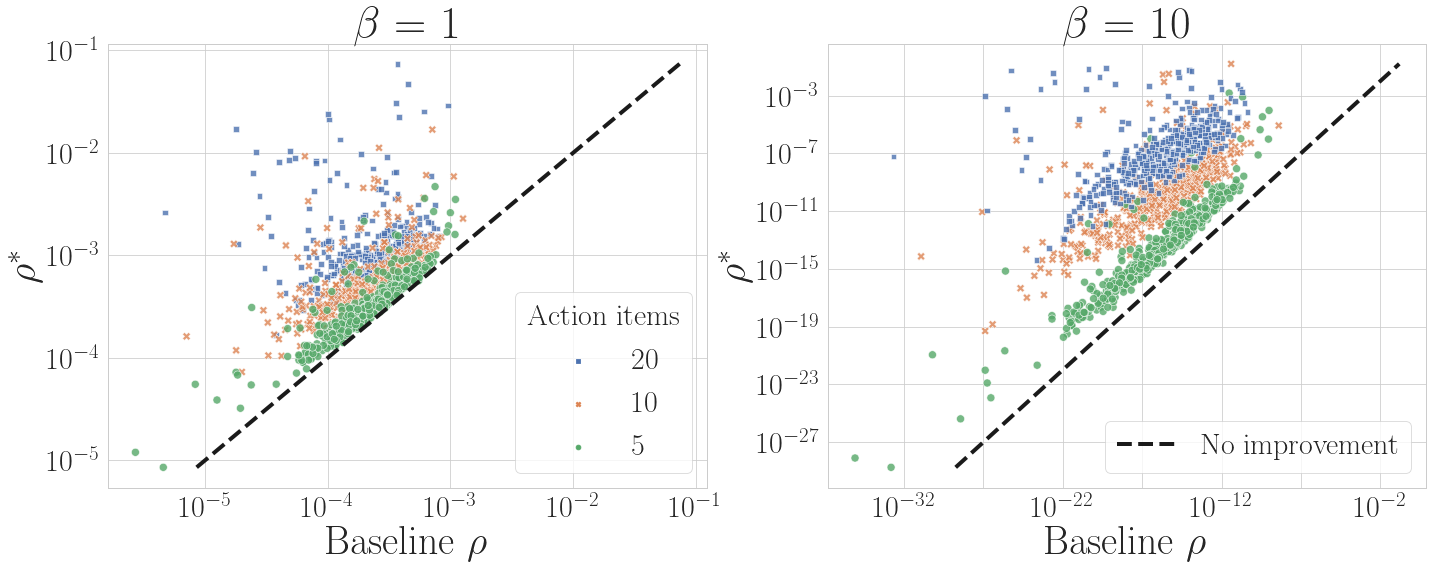

In [3]:
user_exp_df = pd.read_csv(os.path.join('results', 'ml1m_libfm_user_29.csv'))
legend=True
label=None
with context:
    fig, axs = plt.subplots(1,2, figsize=(20,8))
    BETAS = [1, 10]
    K_VALUES = [5,10,20]
    user_exp_df = user_exp_df[user_exp_df['beta'].isin(BETAS)]
    kind_subset_df = user_exp_df[user_exp_df['kind'] == 'random_future']

    for j, beta in enumerate(BETAS):
        subset_df = kind_subset_df[kind_subset_df['beta'] == beta]
        if j == 1:
            label = 'No improvement'
        plot1 = sns.lineplot(x='max_rho_mat', y='max_rho_mat', data = subset_df, ax=axs[j], color = 'k',
                             ls = '--', lw = 4, label = label)
        plot1.set(xscale="log", yscale="log",  xlabel = r'Baseline $\rho$', ylabel = r'$\rho^*$' )
        
        if j==1:
            legend = False
        plot = sns.scatterplot(x='updated_baseline_rho_mat', y='max_rho_mat', data = subset_df,
                               ax=axs[j], hue = 'action_count',palette = 'deep',
                               style='action_count', hue_order = K_VALUES[::-1],
                               alpha = 0.8, s = 65, legend = legend)
        plot.set(xscale="log", yscale="log", xlabel = r'Baseline $\rho$', ylabel = r'$\rho^*$', 
             title = r'$\beta$ = {}'.format(beta))
        axs[j].legend(loc = 'lower right')
    axs[0].get_legend().set_title("Action items")
    for ind, label in enumerate(axs[1].get_xticklabels()):
        if ind % 2 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    plt.tight_layout()

In [4]:
# fig.savefig('k_beta_scatter.pdf', dpi = 100)

## Histograms of max-rho reachability $\rho^\star$ and lift $\lambda^{\star}$

To illustratethe effect of the selection rule stochasticity parameter $\beta$, we vary $\beta \in [1,2,4]$ for `Random Future` action space with `5 action items`.

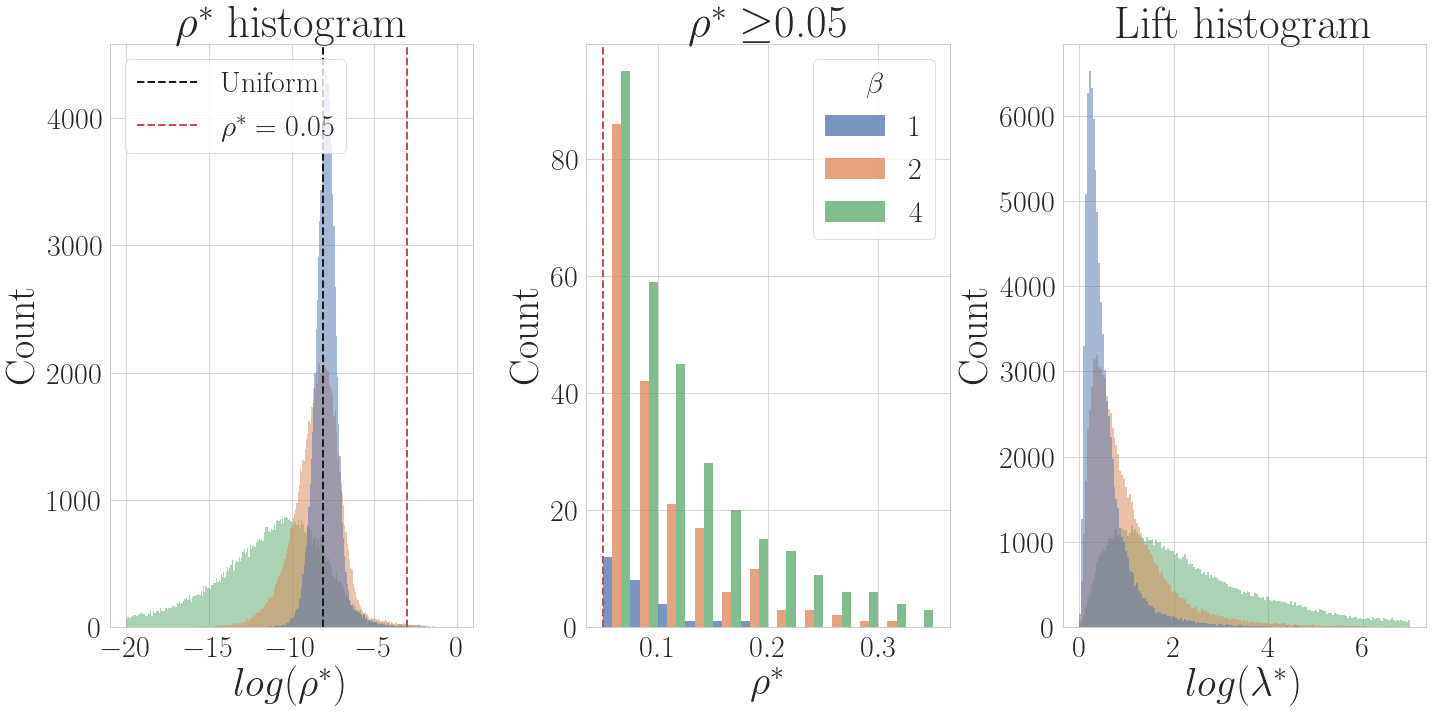

In [5]:
random_future_df = pd.read_csv(os.path.join('results', 'ml1m_libfm_histograms.csv'))
BETAS = [1,2,4]
K=5

with context:
    t_hold = np.log(1/(3706-500))
    x_hold = 0.05
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    p1= sns.histplot(x='log_max_rho', hue='beta', data=random_future_df, 
                 binrange=(-20,0),
                 palette='deep',
                 hue_order = BETAS,
                 ax=axs[0],linewidth=0)
    axs[0].axvline(x=t_hold, color = 'k', lw = 2, ls = '--', label = 'Uniform')
    axs[0].axvline(x=np.log(x_hold), color = 'r', lw = 2, ls = '--', label = r'$\rho^* = 0.05$')
    axs[0].legend()
    axs[0].xaxis.set_major_locator(mticker.MultipleLocator(5))
    axs[0].xaxis.set_major_formatter(mticker.ScalarFormatter())
    p1.set(xlabel=r'$log(\rho^*)$', title = r'$\rho^*$ histogram')
    sns.histplot(x='max_rho_mat', hue='beta', 
                 data=random_future_df[random_future_df['max_rho_mat']> x_hold],
                 palette = 'deep', bins = 12, 
                 binrange=(x_hold, 0.35), hue_order = BETAS, ax=axs[1], multiple = 'dodge',linewidth=0)
    axs[1].axvline(x=x_hold, color = 'r', lw = 2, ls = '--')
    axs[1].set_xlabel(r"$\rho^*$")
    axs[1].set_title(r"$\rho^* \geq ${}".format(x_hold))
    axs[1].xaxis.set_major_locator(mticker.MultipleLocator(0.1))
    axs[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
    axs[1].get_legend().set_title(r"$\beta$")

    p2 =sns.histplot(x='log_lift', hue='beta', data=random_future_df, 
                 binrange=(0,7),
                 hue_order = BETAS,
                 palette = 'deep', legend = False,
                 ax=axs[2], linewidth=0)
    axs[2].set_xlabel(r"$log(\lambda^*)$")
    axs[2].set_title("Lift histogram")
    axs[2].xaxis.set_major_locator(mticker.MultipleLocator(2))
    axs[2].xaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.tight_layout()
    plt.show()

## LibFM vs KNN lift

This plot illustrates the role of action space type

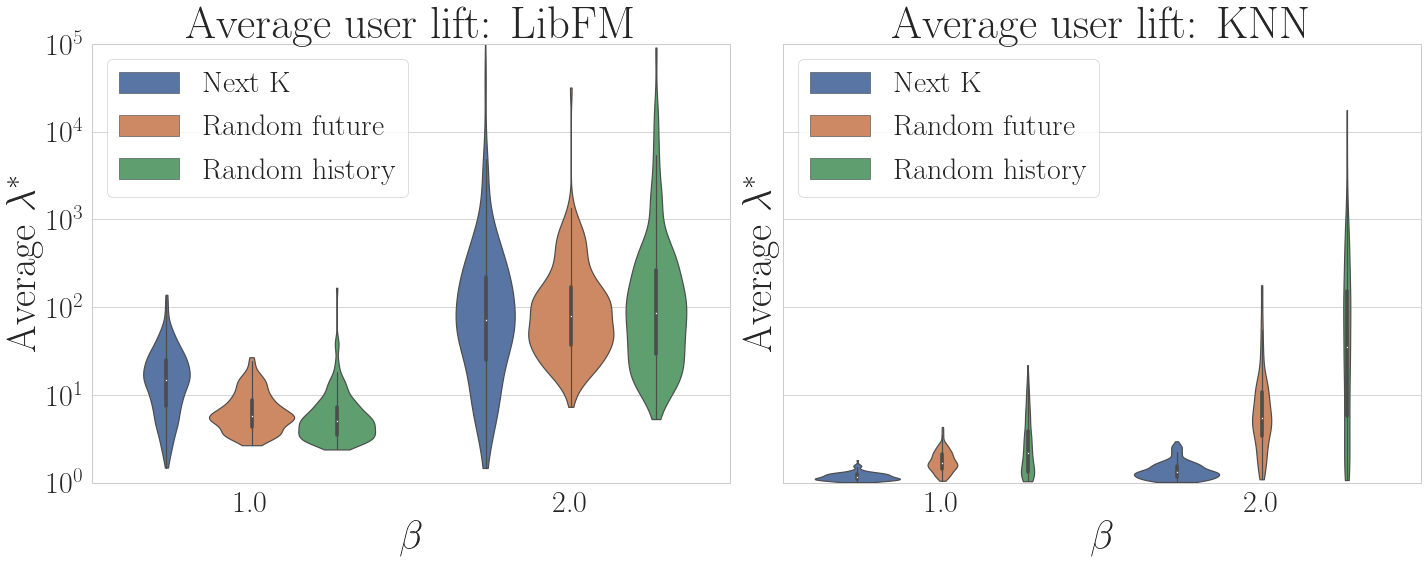

In [6]:
fancy_kind={'next_k': 'Next K', 'random_future': 'Random future', 'random_history': 'Random history'}

with context:
    fig, axs = plt.subplots(1,2, figsize = (20,8), sharey=True)
    y_col = 'new_log_lift'
    df = pd.read_csv(os.path.join('results', 'ml1m_libfm_average_user.csv'))
    p1 = sns.violinplot(x ='beta', y=y_col, data =df[df['new_log_lift']>0], 
                 hue='fancy_kind', dodge = True, cut = 0, scale = 'area', bw = 0.3,
                       hue_order = fancy_kind.values(), 
                       ax = axs[0])
    p1.set(title='Average user lift: LibFM',  xlabel = r'$\beta$', ylabel = r'Average $\lambda^*$', ylim = (0, 5))
    axs[0].legend(loc = 'upper left')
    axs[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    axs[0].yaxis.set_ticks([np.log10(x) for q in range(0, 5) for x in np.linspace(10**q, 10**(q+1), 10)], minor=True)
    
    df = pd.read_csv(os.path.join('results', 'ml1m_knn_average_user.csv'))
    p2 = sns.violinplot(x ='beta', y=y_col, data =df[df['new_log_lift']>0], 
                 hue='fancy_kind', dodge = True, cut = 0, scale = 'area', bw = 0.3,
                       hue_order = fancy_kind.values(), 
                       ax = axs[1])
    p2.set(title='Average user lift: KNN',  xlabel = r'$\beta$', ylabel = r'Average $\lambda^*$', ylim=(0,5))
    axs[1].legend(loc = 'upper left', title = '')
    axs[1].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    axs[1].yaxis.set_ticks([np.log10(x) for q in range(0, 5) for x in np.linspace(10**q, 10**(q+1), 10)], minor=True)
plt.tight_layout()

In [7]:
# fig.savefig('knn_libfm_lift.pdf', dpi = 100)

### Appendix Pictures

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


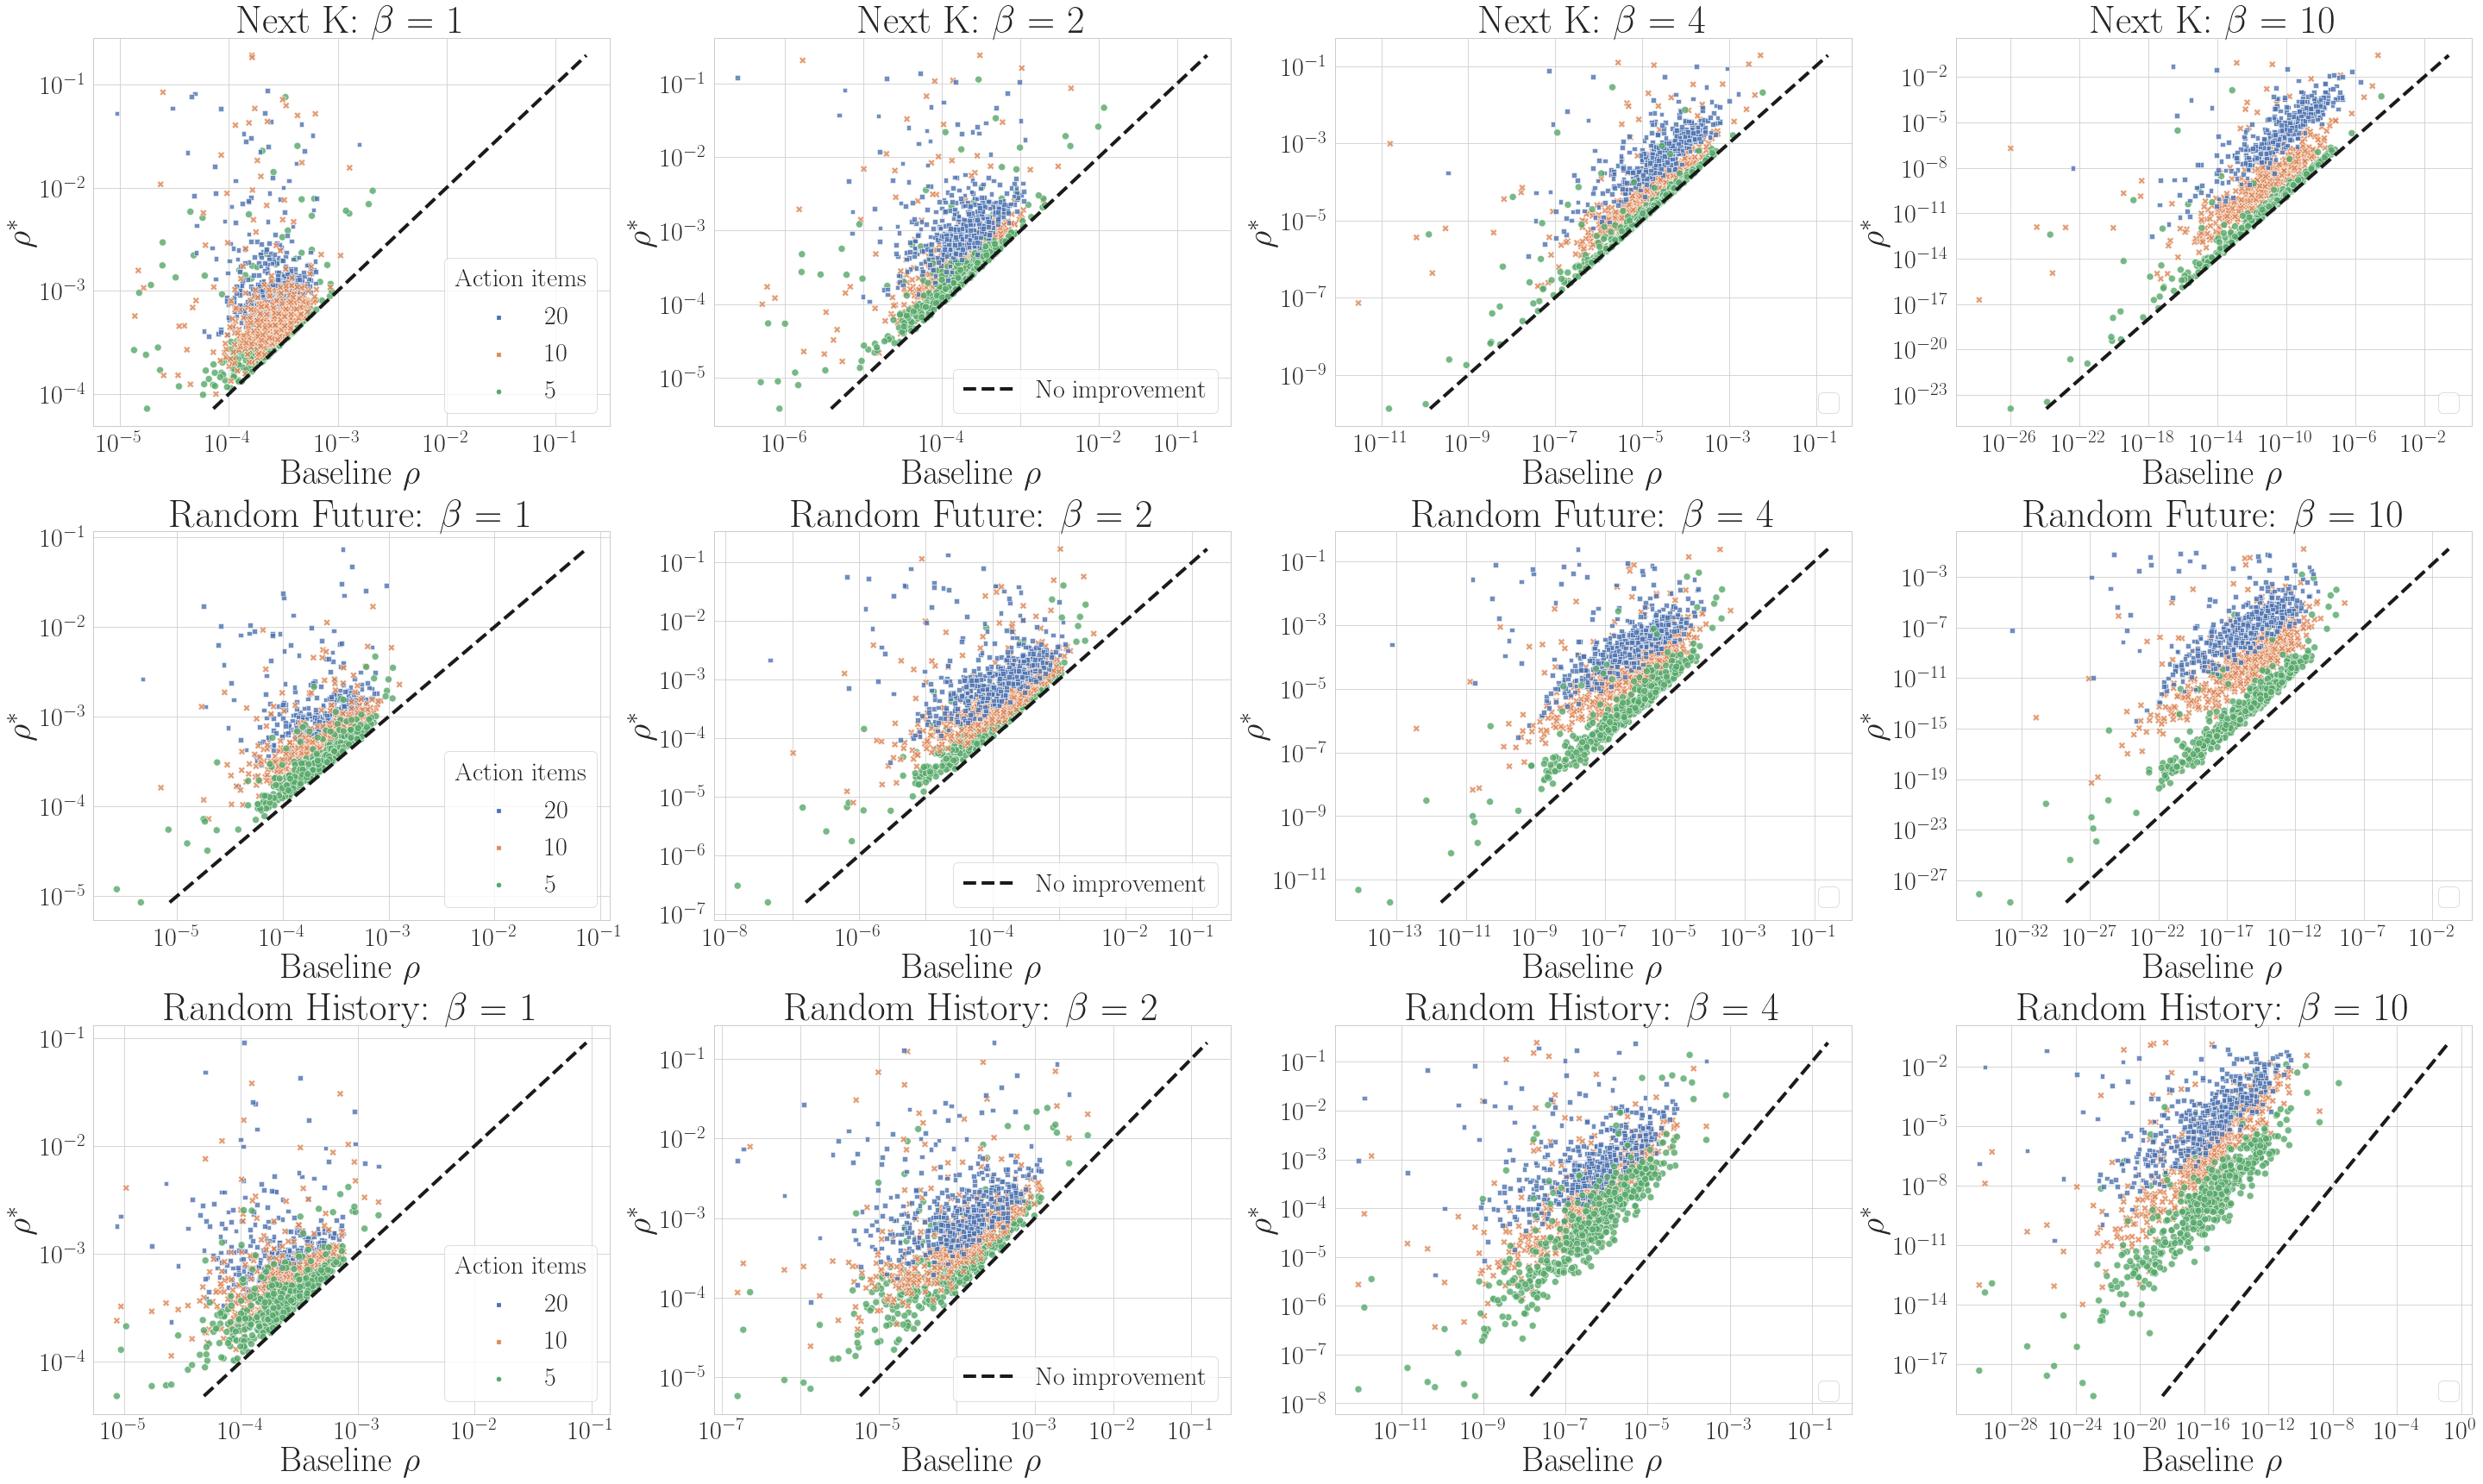

In [8]:
user_exp_df = pd.read_csv(os.path.join('results', 'ml1m_libfm_user_29.csv'))
label=None
kind_map = {'next_k':'Next K', 'random_future':'Random Future', 'random_history': 'Random History',}
with context:
    fig, axs = plt.subplots(3,4, figsize=(40,24))
    BETAS = [1, 2, 4, 10]
    K_VALUES = [5,10,20]
    user_exp_df = user_exp_df[user_exp_df['beta'].isin(BETAS)]
    for i, kind in enumerate(list(kind_map.keys())):
        kind_subset_df = user_exp_df[user_exp_df['kind'] == kind]
        legend=True
        label=None
        for j, beta in enumerate(BETAS):
            subset_df = kind_subset_df[kind_subset_df['beta'] == beta]
            if j == 1:
                label = 'No improvement'
            if j > 1:
                label = ''
            plot1 = sns.lineplot(x='max_rho_mat', y='max_rho_mat', data = subset_df, ax=axs[i,j], color = 'k',
                                 ls = '--', lw = 4, label = label)
            plot1.set(xscale="log", yscale="log",  xlabel = r'Baseline $\rho$', ylabel = r'$\rho^*$' )

            if j>=1:
                legend = False
            plot = sns.scatterplot(x='updated_baseline_rho_mat', y='max_rho_mat', data = subset_df,
                                   ax=axs[i,j], hue = 'action_count',palette = 'deep',
                                   style='action_count', hue_order = K_VALUES[::-1],
                                   alpha = 0.8, s = 65, legend = legend)
            plot.set(xscale="log", yscale="log", xlabel = r'Baseline $\rho$', ylabel = r'$\rho^*$', 
                 title = r'{}: $\beta$ = {}'.format(kind_map[kind], beta))
            axs[i,j].legend(loc = 'lower right')
        axs[i,0].get_legend().set_title("Action items")
        for ind, label in enumerate(axs[i,1].get_xticklabels()):
            if ind % 2 == 0:  # every 2nd label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    plt.tight_layout()

In [9]:
# fig.savefig('libfm_full_scatter.pdf', dpi = 200)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


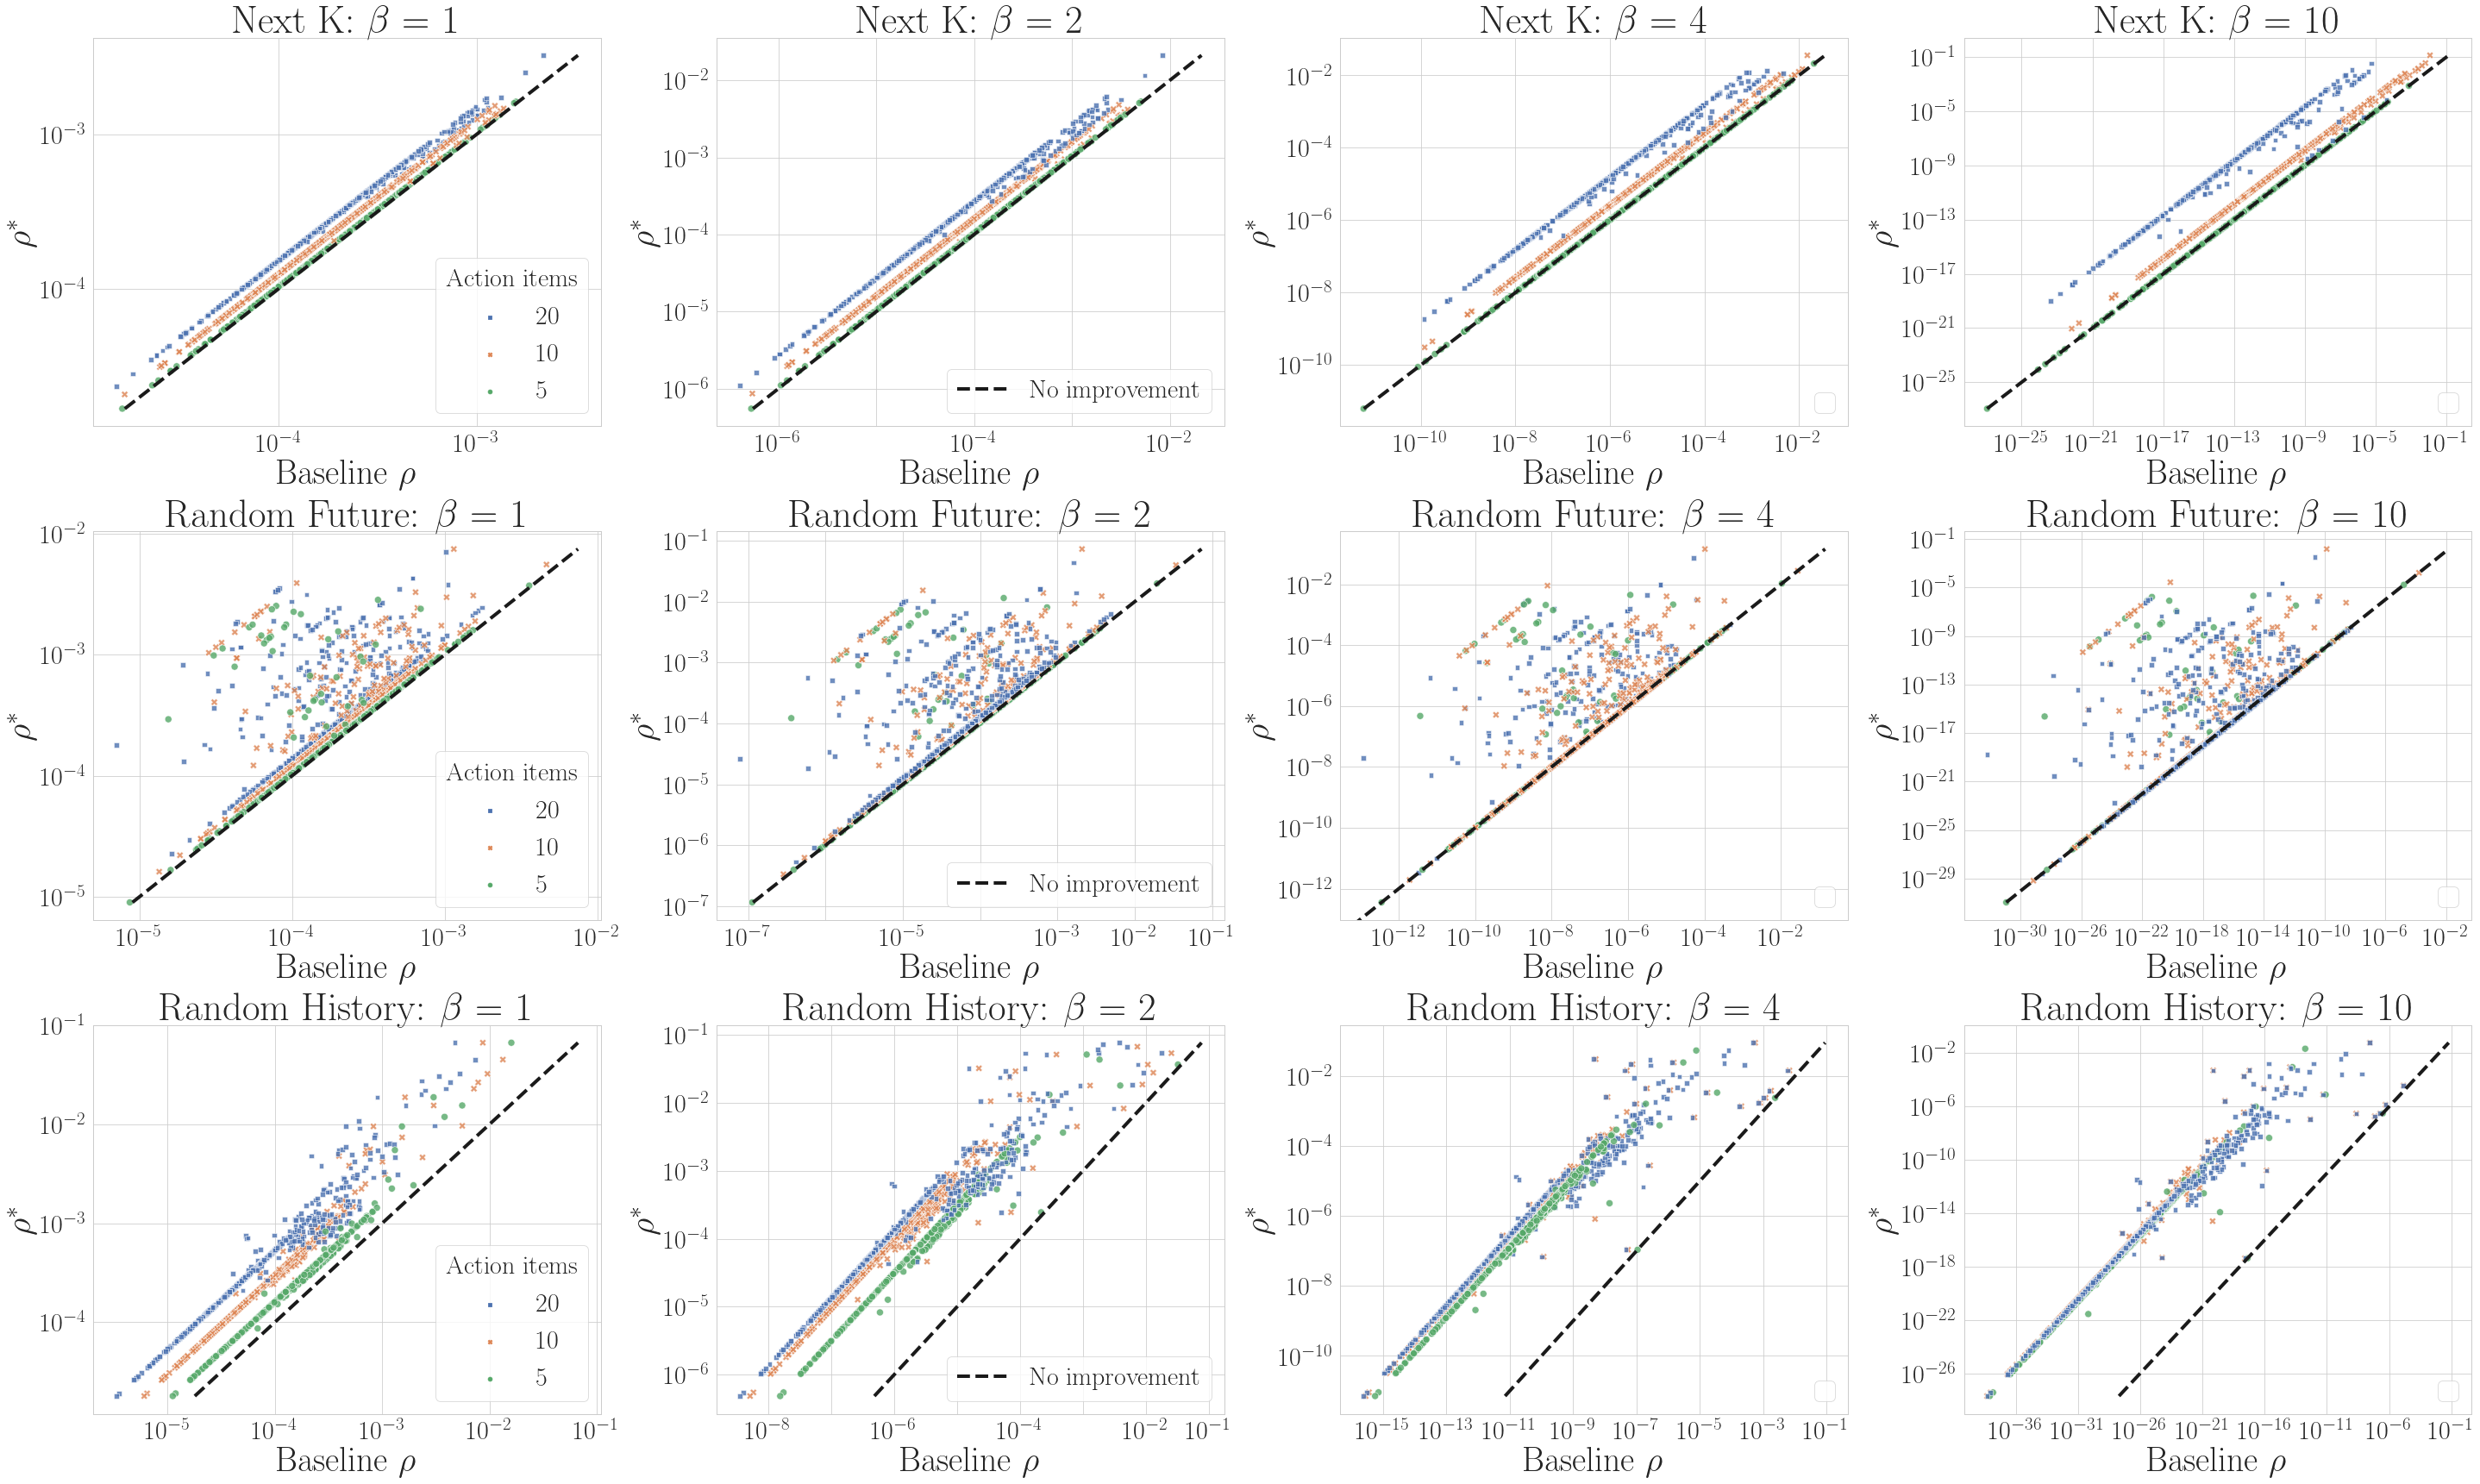

In [10]:
user_exp_df = pd.read_csv(os.path.join('results', 'ml1m_knn_user_29.csv'))
label=None
kind_map = {'next_k':'Next K', 'random_future':'Random Future', 'random_history': 'Random History',}
with context:
    fig, axs = plt.subplots(3,4, figsize=(40,24))
    BETAS = [1, 2, 4, 10]
    K_VALUES = [5,10,20]
    user_exp_df = user_exp_df[user_exp_df['beta'].isin(BETAS)]
    for i, kind in enumerate(list(kind_map.keys())):
        kind_subset_df = user_exp_df[user_exp_df['kind'] == kind]
        legend=True
        label=None
        for j, beta in enumerate(BETAS):
            subset_df = kind_subset_df[kind_subset_df['beta'] == beta]
            if j == 1:
                label = 'No improvement'
            if j > 1:
                label = ''
            plot1 = sns.lineplot(x='max_rho_mat', y='max_rho_mat', data = subset_df, ax=axs[i,j], color = 'k',
                                 ls = '--', lw = 4, label = label)
            plot1.set(xscale="log", yscale="log",  xlabel = r'Baseline $\rho$', ylabel = r'$\rho^*$' )

            if j>=1:
                legend = False
            plot = sns.scatterplot(x='updated_baseline_rho_mat', y='max_rho_mat', data = subset_df,
                                   ax=axs[i,j], hue = 'action_count',palette = 'deep',
                                   style='action_count', hue_order = K_VALUES[::-1],
                                   alpha = 0.8, s = 65, legend = legend)
            plot.set(xscale="log", yscale="log", xlabel = r'Baseline $\rho$', ylabel = r'$\rho^*$', 
                 title = r'{}: $\beta$ = {}'.format(kind_map[kind], beta))
            axs[i,j].legend(loc = 'lower right')
        axs[i,0].get_legend().set_title("Action items")
        for ind, label in enumerate(axs[i,1].get_xticklabels()):
            if ind % 2 == 0:  # every 2nd label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    plt.tight_layout()

In [11]:
# fig.savefig('knn_full_scatter.pdf', dpi = 200)

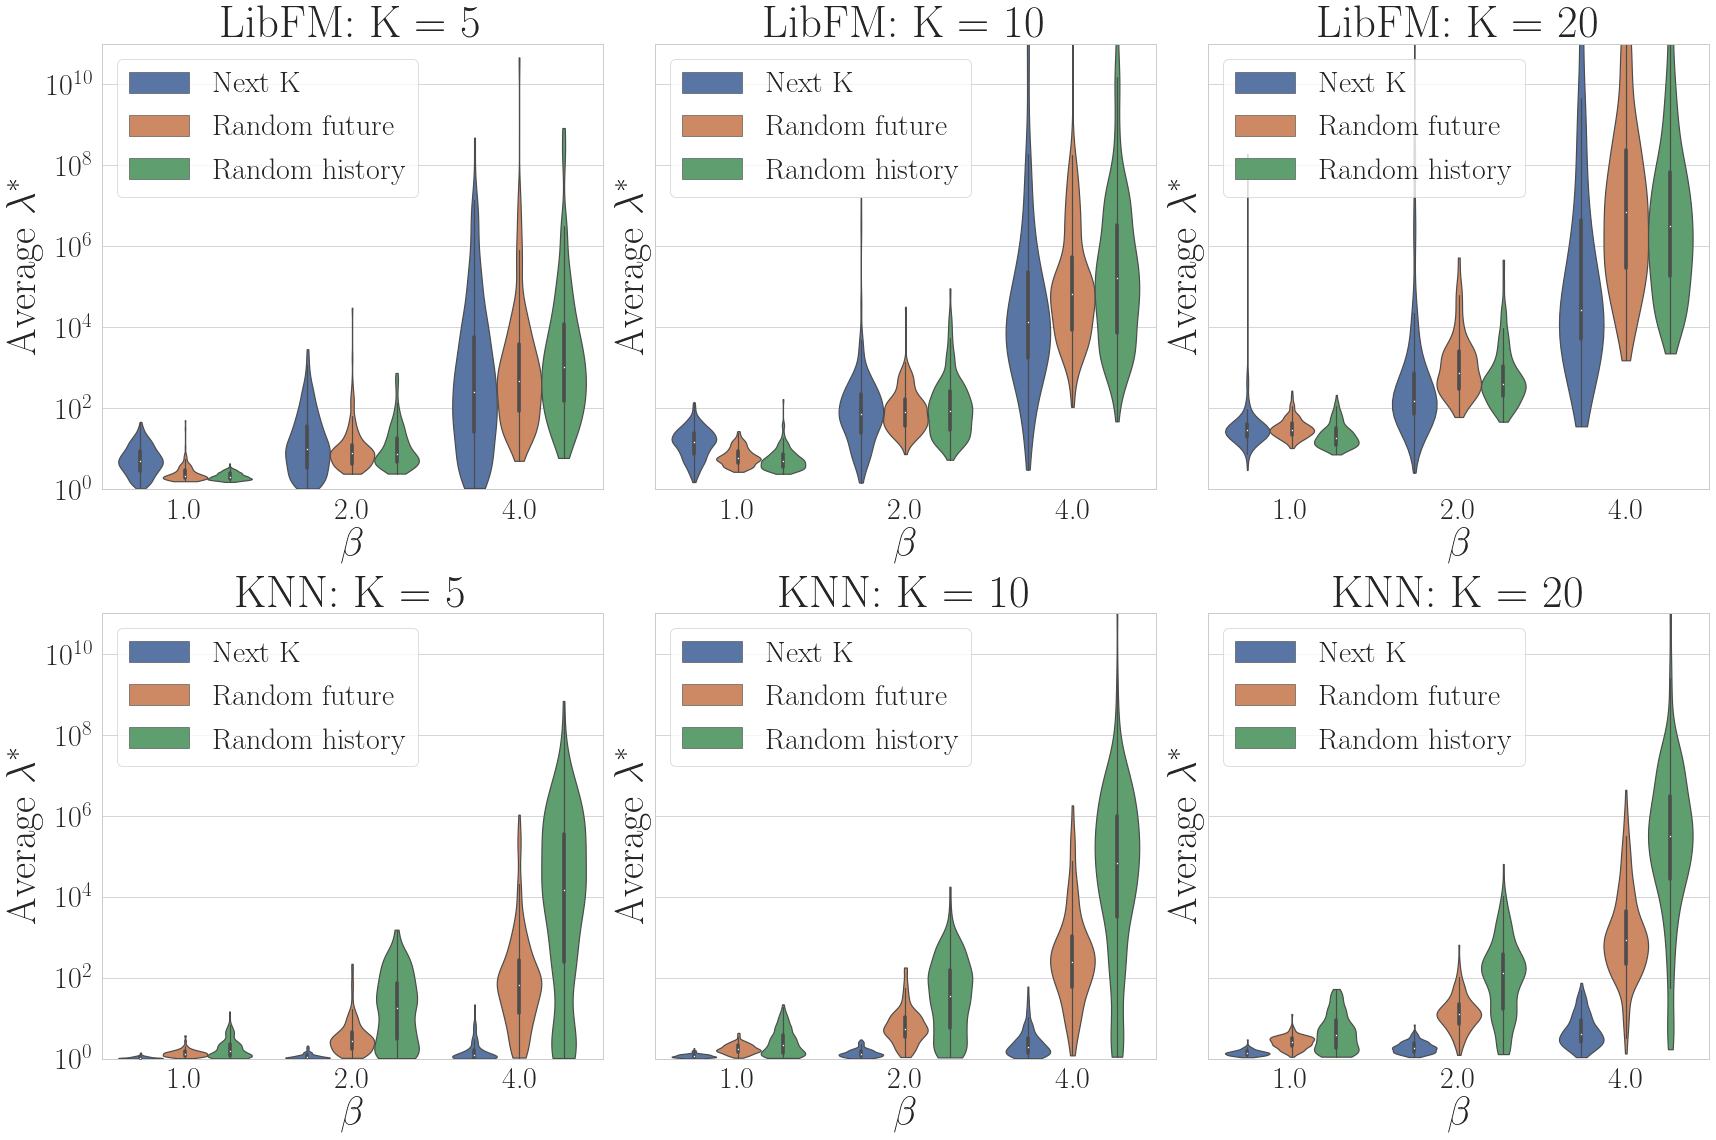

In [12]:
fancy_kind={'next_k': 'Next K', 'random_future': 'Random future', 'random_history': 'Random history'}
legend= True
beta = [1,2, 4]
y_col = 'new_log_lift'

with context:
    fig, axs = plt.subplots(2,3, figsize = (24,16), sharey=True)
    for j, K in enumerate(K_VALUES):        
        df = pd.read_csv(os.path.join('results', 'ml1m_libfm_average_user_{}actions.csv'.format(K)))
        if  j >= 1:
            legend = False
        p1 = sns.violinplot(x ='beta', y=y_col, data =df[df['new_log_lift']>0], 
                     hue='kind', dodge = True, cut = 0, scale = 'width', bw = 0.3,
                           hue_order = fancy_kind.values(), legend = legend, 
                           ax = axs[0,j])
        p1.set(title='LibFM: K = {}'.format(K),  xlabel = r'$\beta$', ylabel = r'Average $\lambda^*$', ylim = (0,11))
        axs[0,j].legend(loc = 'upper left')
        axs[0,j].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        axs[0,j].yaxis.set_ticks([np.log10(x) for q in range(0, 11) for x in np.linspace(10**q, 10**(q+1), 10)], minor=True)

        df = pd.read_csv(os.path.join('results', 'ml1m_knn_average_user_{}actions.csv'.format(K)))
        p2 = sns.violinplot(x ='beta', y=y_col, data =df[df['new_log_lift']>0], 
                     hue='kind', dodge = True, cut = 0, scale = 'width', bw = 0.3, legend=False,
                           hue_order = fancy_kind.values(), 
                           ax = axs[1,j])
        p2.set(title='KNN: K = {}'.format(K),  xlabel = r'$\beta$', ylabel = r'Average $\lambda^*$', ylim=(0,11))
        axs[1,j].legend(loc = 'upper left', title = '')
        axs[1,j].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        axs[1,j].yaxis.set_ticks([np.log10(x) for q in range(0, 11) for x in np.linspace(10**q, 10**(q+1), 10)], minor=True)
plt.tight_layout()

In [13]:
# fig.savefig('violin_full.pdf', dpi = 200)